# 1. Install Dependencies and Setup

In [323]:
!pip install tensorflow opencv-python matplotlib

In [324]:
!pip list

Package                       Version
----------------------------- ---------------
absl-py                       2.1.0
aiobotocore                   2.4.2
aiofiles                      22.1.0
aiohttp                       3.8.3
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
anaconda-catalogs             0.2.0
anaconda-client               1.11.3
anaconda-navigator            2.4.2
anaconda-project              0.11.1
anyascii                      0.3.2
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         22.1.0
Automat  

In [325]:
import tensorflow as tf
import os

In [326]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [327]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# 2. Remove dodgy images

In [429]:
!pip install python-magic

In [430]:
from PIL import Image
import os
import cv2

In [431]:
import cv2
import imghdr

In [432]:
data_dir = 'imagedata'

In [433]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [434]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [435]:
import numpy as np
from matplotlib import pyplot as plt

In [444]:
data = tf.keras.utils.image_dataset_from_directory('imagedata')

Found 300 files belonging to 2 classes.


In [445]:
data_iterator = data.as_numpy_iterator()

In [446]:
batch = data_iterator.next()

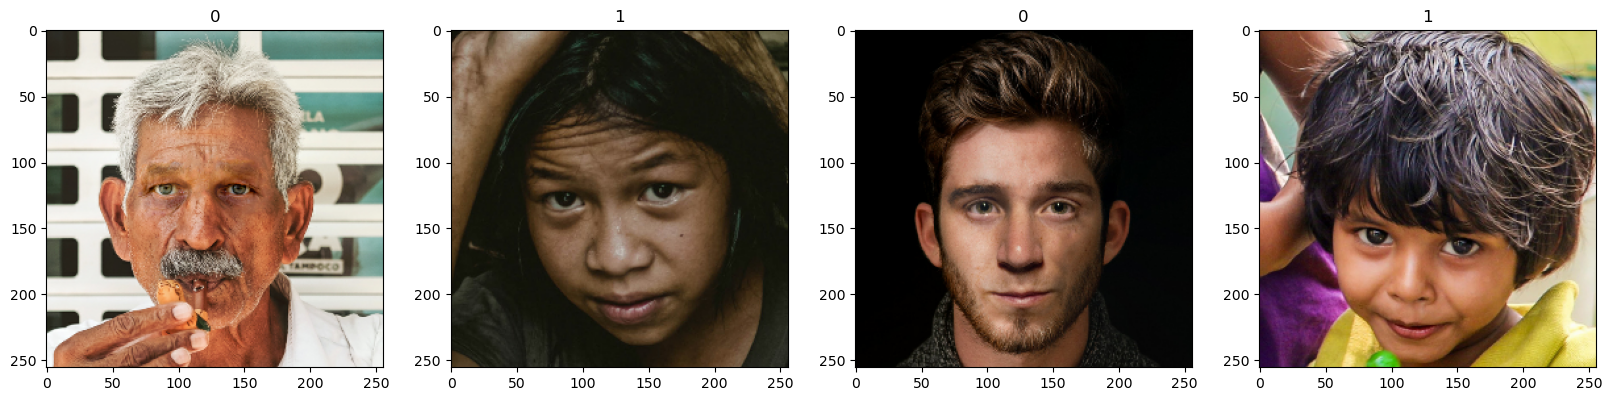

In [447]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [448]:
data = data.map(lambda x,y: (x/255, y))

In [449]:
data.as_numpy_iterator().next()

(array([[[[8.86274517e-01, 8.23529422e-01, 6.90196097e-01],
          [8.86335790e-01, 8.23590696e-01, 6.87601507e-01],
          [8.89249206e-01, 8.26504111e-01, 6.85327649e-01],
          ...,
          [5.84375024e-01, 5.33394635e-01, 3.29473048e-01],
          [5.79105377e-01, 5.28124988e-01, 3.24203432e-01],
          [5.61648846e-01, 5.10668457e-01, 3.06746900e-01]],
 
         [[8.98080409e-01, 8.23570609e-01, 6.94158792e-01],
          [9.01960790e-01, 8.27450991e-01, 6.98040187e-01],
          [9.01960790e-01, 8.27450991e-01, 6.98100507e-01],
          ...,
          [5.71178973e-01, 5.25507450e-01, 3.18811268e-01],
          [5.60601473e-01, 5.13542652e-01, 3.09741676e-01],
          [5.39725959e-01, 4.92667168e-01, 2.88868159e-01]],
 
         [[8.90196085e-01, 8.30269635e-01, 6.95526958e-01],
          [8.94117653e-01, 8.32781851e-01, 7.03414142e-01],
          [8.94117653e-01, 8.30269635e-01, 7.11213231e-01],
          ...,
          [5.54856956e-01, 5.07798135e-01, 3.1352

# 5. Split Data

In [450]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [451]:
train_size

7

In [452]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [453]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [454]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input

In [455]:
model = Sequential([
    Input(shape=(256, 256, 3)),  # Define input shape here
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [456]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [457]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [458]:
logdir='logs'

In [459]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [460]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 512ms/step - accuracy: 0.4361 - loss: 1.4876 - val_accuracy: 0.5312 - val_loss: 0.6901
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 449ms/step - accuracy: 0.4416 - loss: 0.7065 - val_accuracy: 0.4531 - val_loss: 0.6912
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 433ms/step - accuracy: 0.5260 - loss: 0.6906 - val_accuracy: 0.6875 - val_loss: 0.6743
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 432ms/step - accuracy: 0.6298 - loss: 0.6770 - val_accuracy: 0.7188 - val_loss: 0.6313
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 444ms/step - accuracy: 0.7021 - loss: 0.6394 - val_accuracy: 0.6875 - val_loss: 0.6062
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 422ms/step - accuracy: 0.7609 - loss: 0.5566 - val_accuracy: 0.8750 - val_loss: 0.4462
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 451ms/step - accuracy: 0.7896 - loss: 0.4980 - val_accuracy: 0.8750 - val_loss: 0.4002
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 458ms/step - accuracy: 0.8604 - loss: 0.3897 - val_accuracy: 0.8750 - val_loss

# 8. Plot Performance

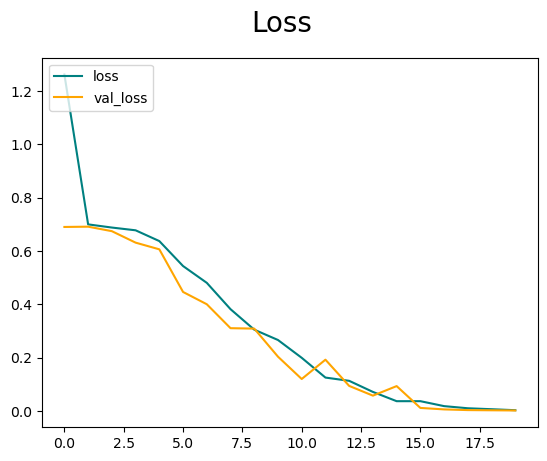

In [461]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

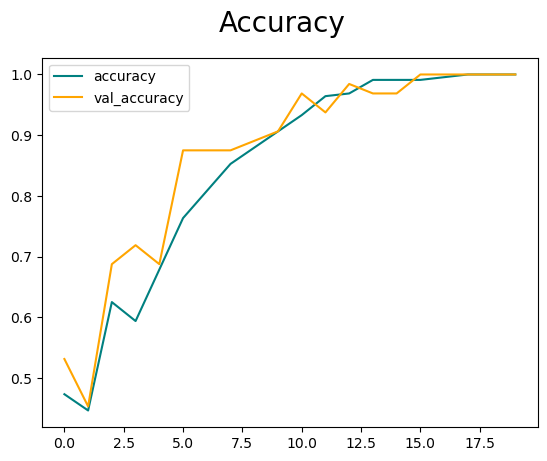

In [462]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [463]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [464]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [465]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


In [466]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [467]:
import cv2

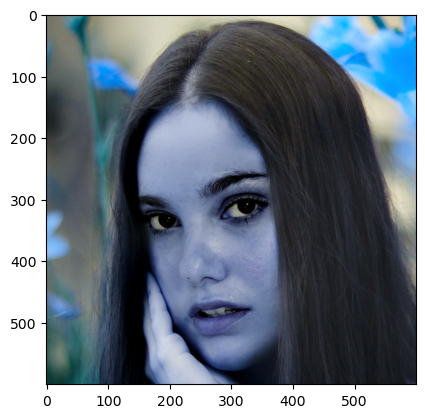

In [479]:
img1 = cv2.imread(r'C:\Users\baner\imagedata\AI_images\AIfaces__ (116).jpg')
plt.imshow(img1)
plt.show()

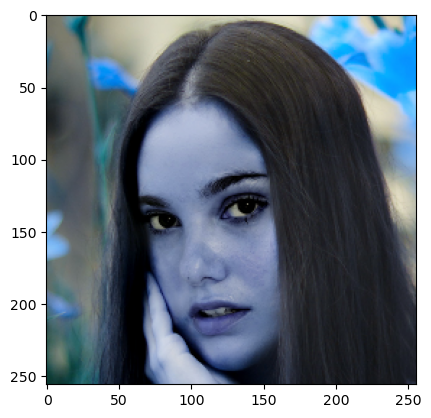

In [480]:
resize = tf.image.resize(img1, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [481]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [482]:
yhat

array([[0.0009091]], dtype=float32)

In [483]:
if yhat < 0.5: 
    print(f'Predicted class is AI Generated image')
else:
    print(f'Predicted class is Real face')

Predicted class is AI Generated image


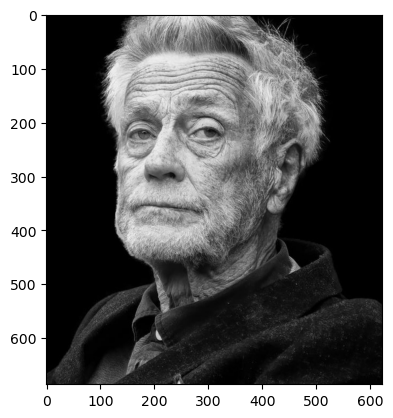

In [484]:
img2 = cv2.imread(r'C:\Users\baner\imagedata\Real_images\Realface_ (4).jpg')
plt.imshow(img2)
plt.show()

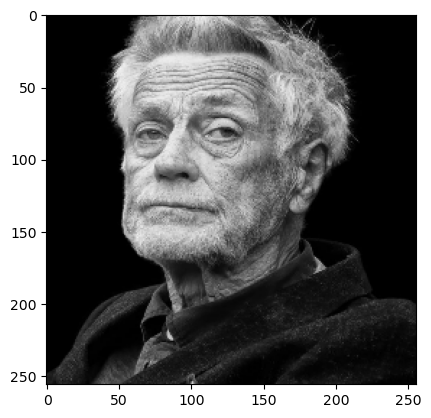

In [485]:
resize = tf.image.resize(img2, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [486]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [487]:
yhat

array([[0.9949921]], dtype=float32)

In [488]:
if yhat < 0.5: 
    print(f'Predicted class is AI Generated image')
else:
    print(f'Predicted class is Real face')

Predicted class is Real face


# 11. Save the Model

In [489]:
from tensorflow.keras.models import load_model

In [490]:
model.save('mymodels/AI_or_Realface_imageclassifier.keras')

In [491]:
new_model = load_model('mymodels/AI_or_Realface_imageclassifier.keras')

In [492]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


array([[0.9949921]], dtype=float32)